<a href="https://colab.research.google.com/github/nandakishore2696/Deep_Learning/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869651%2F1481789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T171449Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0742f77d05307717bc8fcbc2b59a5af6489d545017fa273485d7423d8f65cdf2600b5df651090b325a6508c747055dd8fdf38244a1f1f0e346f2d306e9f6e02cbf135c64d049a1e2b0e5e00979a6483a51d7238b56ebb03d10ff2cc3f907151bc8eb08af6127d5841552513fbff50a772c92b4b2ebd8f43f5f8bb717ddf1609e759ccaaa17e2d5aaa631ec27b2a64fcb9707d946abe4bb301dc26a99f1950cd430e82ea762f01dbd4f619ef6471bb8f0d3e0a23835250ccb5a42cd52af68eb778bdd06ec643960b97807a5e8ea9847f55c9c7c6251cfd2a82a142fd2de31364686428e89fa7def7400f212f7bc95aa23a1973ded1392db19f1451c495a7d6322'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: credit-card-customer-churn-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [11]:
df = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')

In [12]:
df.shape

(10000, 14)

In [13]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6034,6035,15601045,Angelo,655,Spain,Male,37,8,163708.58,2,0,0,76259.23,0
8688,8689,15778418,Burns,637,Germany,Male,40,9,154309.67,1,1,1,125334.16,1
7430,7431,15754578,Okeke,606,France,Female,35,0,135984.15,2,1,0,186778.89,0
9714,9715,15681274,Marshall,726,Spain,Female,56,2,105473.74,1,1,1,46044.70,0
6661,6662,15623346,Czajkowski,820,France,Male,36,4,0.00,2,1,0,31422.69,0


In [14]:
df.drop(columns = ['RowNumber','CustomerId','Surname'],inplace=True)

In [15]:
df.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
477,611,France,Female,40,8,100812.33,2,1,0,147358.27,0
2208,728,France,Female,46,2,109705.52,1,1,0,20276.87,1
3311,513,Spain,Male,72,3,98903.06,1,1,1,81251.24,0
5531,705,France,Female,31,3,119794.67,1,0,0,182528.44,0
5649,629,Spain,Male,29,6,0.00,2,1,1,88842.80,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [19]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [20]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [21]:
df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)

In [22]:
df.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
2425,684,39,4,139723.90,1,1,1,120612.11,0,False,True,False
8173,757,31,1,127320.36,3,1,0,163170.32,0,True,False,True
2645,755,23,5,84284.48,2,1,1,62851.60,0,False,False,True
5975,614,44,6,0.00,2,0,1,104930.46,0,False,False,True
7436,646,57,6,90212.00,1,1,0,13911.27,1,True,False,False


In [23]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [27]:
X_train.shape

(8000, 11)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

In [26]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [28]:
model = Sequential()

model.add(Dense(3,activation='sigmoid', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model.compile(optimizer='Adam', loss='binary_crossentropy')

In [33]:
model.fit(X_train_trf,y_train, epochs = 10)

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4311
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4289
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4271
Epoch 4/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4255
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4239
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4222
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4206
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4189
Epoch 9/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4173
Epoch 10/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4157


In [34]:
model.layers[0].get_weights()

[array([[ 1.5904401e-01,  2.2159847e-03, -1.2674214e-01],
        [-1.9732240e+00, -2.7528450e+00,  3.4961191e-01],
        [ 1.2495363e-01,  3.8430717e-02, -1.2772292e-01],
        [-5.2465063e-02, -2.4262586e-01,  1.9728610e-01],
        [-1.8791221e-01, -6.7777477e-02, -2.1554916e+00],
        [-7.9468347e-02,  1.7181417e-01, -2.4022892e-02],
        [ 8.2422799e-01,  2.5976500e-01, -7.5756764e-01],
        [-7.5795047e-02, -6.3852876e-02,  1.5684005e-02],
        [-1.0487469e+00, -2.4268860e-01,  2.6311263e-01],
        [-4.3376729e-02,  4.7738221e-02,  1.8960720e-01],
        [ 4.9963963e-01,  3.9669642e-01, -5.2953053e-01]], dtype=float32),
 array([ 0.60845375,  0.20451522, -0.79941165], dtype=float32)]

In [35]:
model.layers[1].get_weights()

[array([[-1.6726538 ],
        [-0.98938197],
        [ 0.9088107 ]], dtype=float32),
 array([-0.45251235], dtype=float32)]

In [36]:
model.predict(X_test_trf)

63/63 [==============================] - 0s 2ms/step


array([[0.25364074],
       [0.377205  ],
       [0.19383709],
       ...,
       [0.10778719],
       [0.11910783],
       [0.19520102]], dtype=float32)

In [37]:
y_log = model.predict(X_test_trf)

63/63 [==============================] - 0s 2ms/step


In [38]:
y_pred = np.where(y_log>0.5,1,0)

In [39]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.823

# Increase accuracy
* Increase Epochs to 100

In [41]:
model = Sequential()

model.add(Dense(3,activation='sigmoid', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy')
model.fit(X_train_trf,y_train, epochs = 100)
y_log = model.predict(X_test_trf)
y_pred = np.where(y_log>0.5,1,0)
accuracy_score(y_test,y_pred)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 2s 5ms/step - loss: 0.5543
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 0.4998
Epoch 3/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4719
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 0.4565
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4471
Epoc

0.8425

* Activation Function - Relu

In [44]:
model = Sequential()

model.add(Dense(3,activation='relu', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy')
model.fit(X_train_trf,y_train, epochs = 100)
y_log = model.predict(X_test_trf)
y_pred = np.where(y_log>0.5,1,0)
accuracy_score(y_test,y_pred)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.5463
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4810
Epoch 3/100
250/250 [==============================] - 1s 2ms/step - loss: 0.4554
Epoch 4/100
250/250 [==============================] - 1s 2ms/step - loss: 0.4422
Epoch 5/100
250/250 [==============================] - 1s 2ms/step - loss: 0.4343
Epoc

0.8575

* Increase number of nodes to 10

In [45]:
model = Sequential()

model.add(Dense(10,activation='relu', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy')
model.fit(X_train_trf,y_train, epochs = 100)
y_log = model.predict(X_test_trf)
y_pred = np.where(y_log>0.5,1,0)
accuracy_score(y_test,y_pred)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                120       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 0.6349
Epoch 2/100
250/250 [==============================] - 1s 2ms/step - loss: 0.4825
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4479
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4322
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4209
Ep

0.858

* Increase number of Hindden layers

In [46]:
model = Sequential()

model.add(Dense(10,activation='relu', input_dim = 11))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy')
model.fit(X_train_trf,y_train, epochs = 100)
y_log = model.predict(X_test_trf)
y_pred = np.where(y_log>0.5,1,0)
accuracy_score(y_test,y_pred)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                120       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 351 (1.37 KB)
Trainable params: 351 (1.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 3s 3ms/step - loss: 0.5211
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss:

0.8555

* accuracy
* split

In [51]:
model = Sequential()

model.add(Dense(10,activation='relu', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_trf,y_train, epochs = 100, validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                120       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 2s 7ms/step - loss: 0.9792 - accuracy: 0.3258 - val_loss: 0.6913 - val_accuracy: 0.5556
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5835 - accuracy: 0.7350 - val_loss: 0.5206 - val_accuracy: 0.7994
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4834 - accuracy: 0.8106 - val_loss: 0.4674 - val

In [52]:
y_log = model.predict(X_test_trf)
y_pred = np.where(y_log>0.5,1,0)
accuracy_score(y_test,y_pred)

63/63 [==============================] - 0s 7ms/step


0.8615

In [53]:
model = Sequential()

model.add(Dense(10,activation='relu', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy')
history = model.fit(X_train_trf,y_train, epochs = 100)
#y_log = model.predict(X_test_trf)
#y_pred = np.where(y_log>0.5,1,0)
#accuracy_score(y_test,y_pred)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 10)                120       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.5379
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4552
Epoch 3/100
250/250 [==============================] - 1s 6ms/step - loss: 0.4307
Epoch 4/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4179
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4067
E

In [54]:
history.history

{'loss': [0.53787761926651,
  0.4551905393600464,
  0.4306776523590088,
  0.41790077090263367,
  0.4067230224609375,
  0.39650872349739075,
  0.38638895750045776,
  0.3778391182422638,
  0.3703239858150482,
  0.36445948481559753,
  0.35987523198127747,
  0.3563131093978882,
  0.3539806604385376,
  0.35199254751205444,
  0.35064736008644104,
  0.3494728207588196,
  0.348565936088562,
  0.34780460596084595,
  0.34745532274246216,
  0.34689587354660034,
  0.34640780091285706,
  0.34590744972229004,
  0.3456547260284424,
  0.3453506529331207,
  0.345033198595047,
  0.34475046396255493,
  0.34451425075531006,
  0.3445589542388916,
  0.3442292809486389,
  0.34378769993782043,
  0.3437396287918091,
  0.34352099895477295,
  0.34320810437202454,
  0.3430469334125519,
  0.34324920177459717,
  0.3428875207901001,
  0.3427329957485199,
  0.34285950660705566,
  0.34259310364723206,
  0.34245550632476807,
  0.3426317870616913,
  0.34222710132598877,
  0.3422570824623108,
  0.3422391414642334,
  0.34

In [55]:
model = Sequential()

model.add(Dense(5,activation='relu', input_dim = 11))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train_trf,y_train, epochs = 100, validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 5)                 60        
                                                                 
 dense_25 (Dense)            (None, 1)                 6         
                                                                 
Total params: 66 (264.00 Byte)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.6813 - accuracy: 0.6030 - val_loss: 0.5572 - val_accuracy: 0.7244
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5061 - accuracy: 0.7778 - val_loss: 0.4826 - val_accuracy: 0.7894
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4605 - accuracy: 0.8092 - val_loss: 0.4548 - val_a

In [56]:
history.history

{'loss': [0.6812889575958252,
  0.5061374306678772,
  0.4604688882827759,
  0.44002434611320496,
  0.4264441430568695,
  0.41600286960601807,
  0.40692031383514404,
  0.3984060287475586,
  0.3905807137489319,
  0.3832838833332062,
  0.37639227509498596,
  0.37031927704811096,
  0.36501336097717285,
  0.36060699820518494,
  0.357041597366333,
  0.3541972041130066,
  0.3517449200153351,
  0.3499859571456909,
  0.34835395216941833,
  0.3470117449760437,
  0.3458739221096039,
  0.3447116017341614,
  0.3439440429210663,
  0.3434358239173889,
  0.3429441452026367,
  0.3424358367919922,
  0.3420528471469879,
  0.34193068742752075,
  0.3415989577770233,
  0.3414870500564575,
  0.34114906191825867,
  0.34116336703300476,
  0.3408086895942688,
  0.3406398296356201,
  0.3406429588794708,
  0.3406030237674713,
  0.3405197262763977,
  0.34035882353782654,
  0.33994320034980774,
  0.3399556875228882,
  0.339796245098114,
  0.3397979438304901,
  0.3396260440349579,
  0.33951401710510254,
  0.33946606

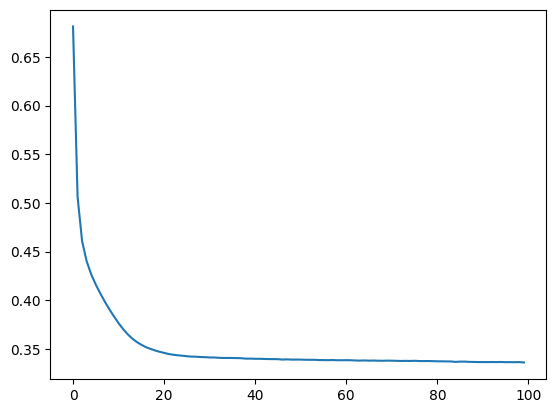

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

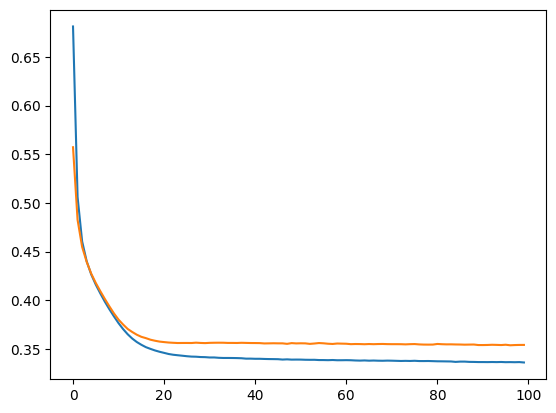

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

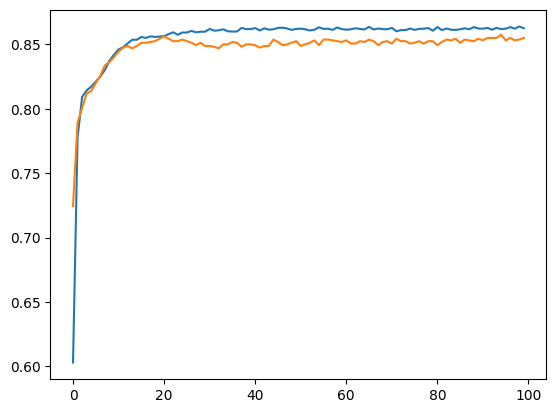

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])